<a href="https://colab.research.google.com/github/camillabocciolone/Leonardo-project/blob/main/octuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import necessari librerie e files

## import libraries

In [ ]:
!pip -q install einops tqdm scikit-learn scipy

import os, sys, numpy as np, torch
from pathlib import Path
from scipy.signal import resample_poly
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import os, json
import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt, iirnotch, resample_poly, detrend
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader



## --- Repo EEGPT ---

In [ ]:
# (opzionale) aggiorna pip/setuptools/wheel per massimizzare compatibilità
!pip install -U pip setuptools wheel

# install minimo per il tuo script
!pip install numpy scipy scikit-learn einops tqdm

# torch: in Colab di solito è già installato; se no:
!pip install torch --index-url https://download.pytorch.org/whl/cpu



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


Looking in indexes: https://download.pytorch.org/whl/cpu


## montare il drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Usa il checkpoint direttamente da Drive

In [ ]:
from pathlib import Path

ckpt_path = Path(
    "/content/drive/MyDrive/EEGPT/checkpoint/eegpt_mcae_58chs_4s_large4E.ckpt"
)

print("Checkpoint exists:", ckpt_path.exists())


Checkpoint exists: True


## Clona il repo

In [ ]:
from pathlib import Path
import os

%cd /content
if not Path("/content/EEGPT").exists():
    !git clone -q https://github.com/BINE022/EEGPT.git

print("Repo OK:", Path("/content/EEGPT").exists())
print("Has downstream:", Path("/content/EEGPT/downstream").exists())


/content
Repo OK: True
Has downstream: True


## Import del modello

In [ ]:
import importlib.util
from pathlib import Path

path = Path("/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py")
print("Model file exists:", path.exists(), path)

spec = importlib.util.spec_from_file_location("eegpt_mcae_finetune", str(path))
mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mod)

EEGPTClassifier = mod.EEGPTClassifier
CHANNEL_DICT = mod.CHANNEL_DICT

print("Import OK. CHANNEL_DICT size:", len(CHANNEL_DICT))


Model file exists: True /content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py
Import OK. CHANNEL_DICT size: 62


/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py:679: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(True)
/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py:693: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(True)


## Installa Optuna + Dashboard

In [ ]:
!pip -q install optuna optuna-dashboard


# EEGPT on the true dataset

In [ ]:
data_dir = "/content/drive/My Drive/LL2/LL2/raw_data"

levels = ["highlevel", "midlevel", "lowlevel", "natural"]   # y=0,1,2
tasks  = ["Stroop"]
subjects = range(1, 16)

C = 8
fs_in = 250
FS_OUT = 256
EPOCH_SEC, STRIDE_SEC = 4.0, 2.0
BP_LO, BP_HI = 0.5, 45.0
NOTCH_F0, NOTCH_Q = 50.0, 30.0

# canali OpenBCI (devono essere in CHANNEL_DICT)
my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
use_channels_names = [c.upper().strip('.') for c in my_channels]
for c in use_channels_names:
    assert c in CHANNEL_DICT, f"Canale non riconosciuto in CHANNEL_DICT: {c}"
print("Use channels:", use_channels_names)


Use channels: ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'C2']


## definiamo funzioni per la lettura e preprocessing dei dati

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

def find_file(level, task, subject):
    # layout A: {level}_Data/{task}-{subject}.txt
    p1 = os.path.join(data_dir, f"{level}_Data", f"{task}-{subject}.txt")
    # layout B: {task}_Data/{level}-{subject}.txt
    p2 = os.path.join(data_dir, f"{task}_Data",  f"{level}-{subject}.txt")
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    return None

def load_ct_matrix(path, C=8):
    df = pd.read_csv(path, sep=",", header=None, engine="python")
    df = df.iloc[1:, :].reset_index(drop=True)

    # EEG: prime C colonne → (T,C)
    X = df.iloc[:, :C].to_numpy(dtype=np.float32)

    # TIME (se ti serve)
    T = X.shape[0]
    t = np.arange(T) / 250.0

    return X, t   # X:(T,C)


def bandpass(x, fs, lo=BP_LO, hi=BP_HI, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lo/nyq, hi/nyq], btype="band")
    return filtfilt(b, a, x, axis=0)

def notch50(x, fs, f0=NOTCH_F0, Q=NOTCH_Q):
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, x, axis=0)

def resample_to(x, fs_in, fs_out):
    if fs_in == fs_out:
        return x
    # per 250->256 puoi usare direttamente 128/125
    if int(fs_in)==250 and int(fs_out)==256:
        return resample_poly(x, 128, 125, axis=0)
    # fallback generico
    from math import gcd
    g = gcd(int(fs_in), int(fs_out))
    up, down = fs_out//g, fs_in//g
    return resample_poly(x, up, down, axis=0)

def robust_clip(x, q=0.999):
    hi = np.quantile(x, q, axis=0, keepdims=True)
    lo = np.quantile(x, 1-q, axis=0, keepdims=True)
    return np.clip(x, lo, hi)

def epoch_signal(x_tc, fs, epoch_sec=EPOCH_SEC, stride_sec=STRIDE_SEC):
    # x_tc: (T,C)
    win = int(epoch_sec * fs)
    step = int(stride_sec * fs)
    T = x_tc.shape[0]
    starts = np.arange(0, T - win + 1, step)
    if len(starts)==0:
        return np.empty((0, win, x_tc.shape[1]), dtype=np.float32)
    epochs = np.stack([x_tc[s:s+win] for s in starts], axis=0)  # (N, win, C)
    return epochs

def preprocess_recording(X, t=None, debug=False, ch_idx=0):
    # X: (T,C), t: (T,) in secondi (o ms), monotono

    # filtri: non cambiano la lunghezza

    # 1) preprocess leggero a 250 (opzionale, ma ok)
    x = detrend(X, axis=0, type="linear")
    x = robust_clip(x, q=0.999)

    # 2) resample 250 -> 256
    x = resample_to(x, fs_in, FS_OUT)               # (T256, C)
    t_256 = t[0] + np.arange(x.shape[0]) / FS_OUT   # (T256,)

    # 3) filtri a 256 (coerenti col segnale)
    x = bandpass(x, FS_OUT)
    x = notch50(x, FS_OUT)

    if debug:
        plt.figure(figsize=(12,4))
        plt.plot(t, X[:, ch_idx], '.', alpha=0.4, label="original (250 Hz)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    # 4) epoche a 256
    epochs_tc = epoch_signal(x, FS_OUT)  # (N, win, C)
    if epochs_tc.shape[0] == 0:
        win = int(EPOCH_SEC * FS_OUT)
        return np.empty((0, X.shape[1], win), dtype=np.float32), None

    epochs = np.transpose(epochs_tc, (0, 2, 1))  # (N, C, win)

    win = int(EPOCH_SEC * FS_OUT)
    step = int(STRIDE_SEC * FS_OUT)
    starts = np.arange(0, x.shape[0] - win + 1, step)
    t_epochs = np.stack([t_256[s:s+win] for s in starts], axis=0)  # (N, win)

    if debug and epochs.shape[0] > 0:
        e = 23
        if e >= epochs.shape[0]:
            e = 0  # fallback se hai meno di 24 epoche

        plt.figure(figsize=(12,4))
        plt.plot(t_epochs[e], epochs[e, ch_idx, :])
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title(f"Epoch[{e}] (ch {ch_idx})")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


    # 5) robust z-score per epoca/canale
    med = np.median(epochs, axis=-1, keepdims=True)
    mad = np.median(np.abs(epochs - med), axis=-1, keepdims=True) + 1e-8
    #epochs = (epochs - med) / (1.4826 * mad)
    if debug and epochs.shape[0] > 0:
        e = 23
        if e >= epochs.shape[0]:
            e = 0  # fallback se hai meno di 24 epoche

        plt.figure(figsize=(12,4))
        plt.plot(t_epochs[e], epochs[e, ch_idx, :])
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title(f"Epoch[{e}] (ch {ch_idx})")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return epochs.astype(np.float32), t_epochs







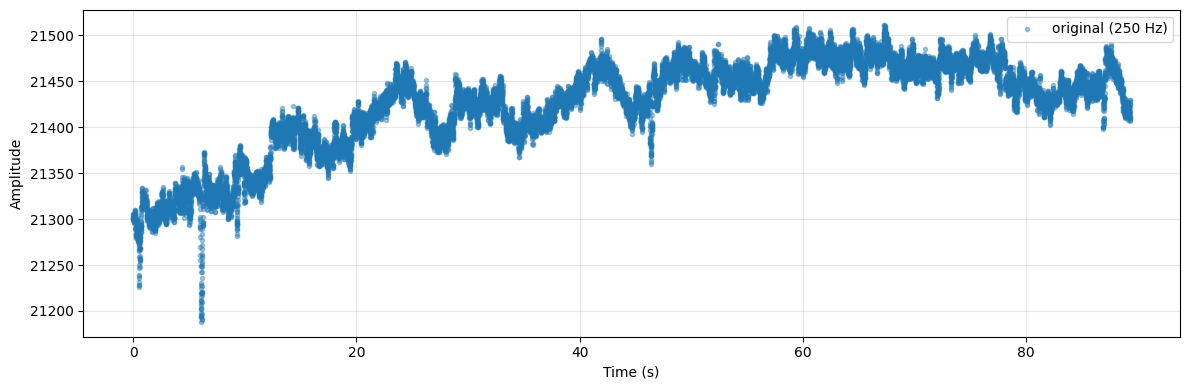

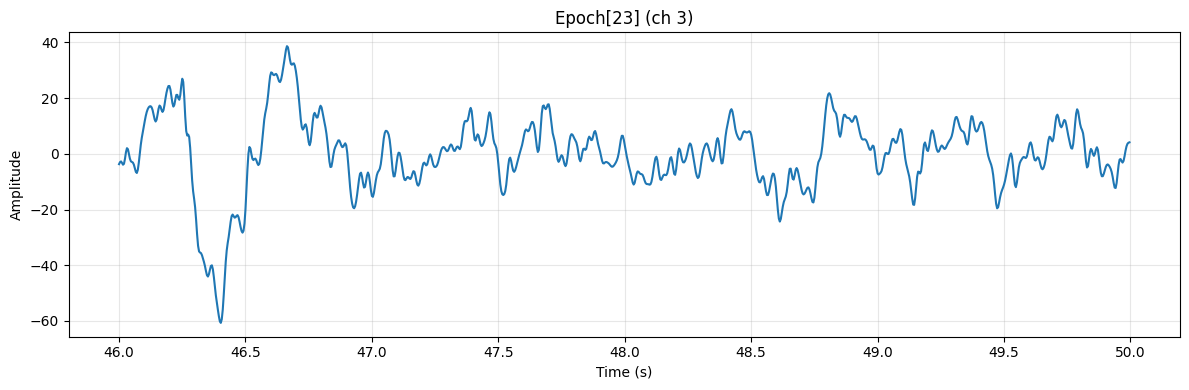

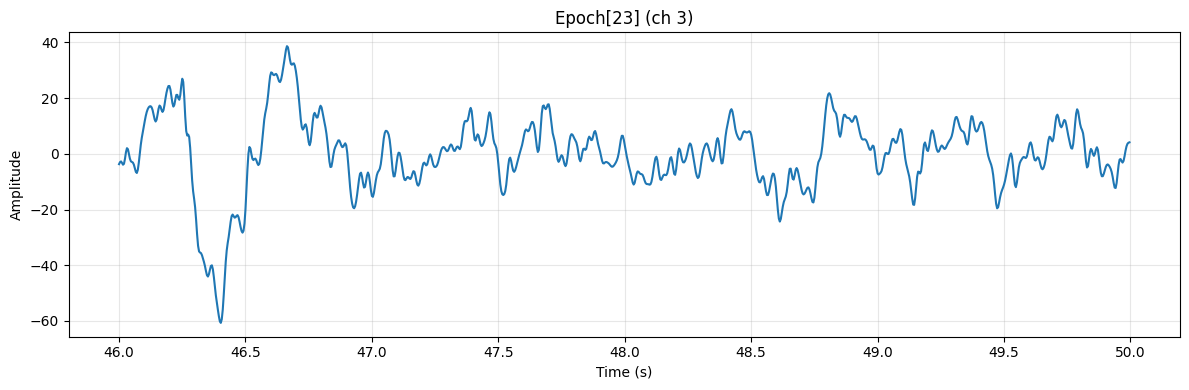

(43, 8, 1024)


In [ ]:
task = "Stroop"
level = "lowlevel"
subject = 8

path = find_file(level, task, subject)
X, t = load_ct_matrix(path)

epochs, t_epochs = preprocess_recording(
    X, t,
    debug=True,
    ch_idx=3
)

print(epochs.shape)  # (N, C, win)




## build_all

**definiamo build all usando rec_id**

**Scopo**: oltre a subject, crea anche un ID del recording in modo che si possa fare split “a livello di registrazione” (recording-level) e poi prendere tutte le finestre di quella registrazione insieme

In [ ]:
def build_all(levels, tasks, subjects, C=8):
    X_list, y_list, subj_list, rec_list = [], [], [], []
    for li, level in enumerate(levels):
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    print(f"[SKIP] missing file: {level}/{task}/S{s}")
                    continue
                try:

                    X, t = load_ct_matrix(path, C=C)
                    epochs, _ = preprocess_recording(X, t=t)
                    if epochs.shape[0]==0:
                        print(f"[SKIP] no epochs: {os.path.basename(path)}")
                        continue

                    rec_id = f"{task}|{level}|S{s}"
                    X_list.append(epochs)
                    y_list.extend([li] * len(epochs))
                    subj_list.extend([f"S{s}"]*len(epochs))
                    rec_list.extend([rec_id]*len(epochs))
                except Exception as e:
                    print(f"[ERROR] {os.path.basename(path)}: {e}")
                    continue

    X_all = np.concatenate(X_list, axis=0) if X_list else np.empty((0,C,int(EPOCH_SEC*FS_OUT)), dtype=np.float32)
    y_all = np.array(y_list, dtype=np.int64)
    meta = {
        "subject": np.array(subj_list),
        "rec_id":  np.array(rec_list),
    }
    return X_all, y_all, meta

X_all, y_all, meta = build_all(levels, tasks, subjects, C=8)
print("X_all:", X_all.shape, "y_all:", y_all.shape, "unique rec:", len(np.unique(meta["rec_id"])))


X_all: (2520, 8, 1024) y_all: (2520,) unique rec: 60


In [ ]:
X_all = np.asarray(X_all)
y_all = np.asarray(y_all)

meta["rec_id"]  = np.asarray(meta["rec_id"]).astype(str).reshape(-1)
meta["subject"] = np.asarray(meta["subject"]).astype(str).reshape(-1)

assert len(meta["rec_id"])  == len(y_all) == X_all.shape[0]
assert len(meta["subject"]) == len(y_all)


## recording-level prediction

Questo blocco serve a fare cross-validation a livello di registrazione (non di finestra), mantenendo l’indipendenza tra soggetti, e poi usare quei recording per selezionare le finestre giuste

In [ ]:
print("X_all:", X_all.shape)
print("y_all:", y_all.shape, "meta rec:", meta["rec_id"].shape)
print("unique rec:", len(np.unique(meta["rec_id"])))


X_all: (2520, 8, 1024)
y_all: (2520,) meta rec: (2520,)
unique rec: 60


In [ ]:
rec_id_win = meta["rec_id"].astype(str)
subj_win   = meta["subject"].astype(str)

rec_ids = np.unique(rec_id_win)
rec_to_subj = {rid: rid.split("|")[-1] for rid in rec_ids}  # oppure costruita da meta
rec_subj = np.array([rec_to_subj[r] for r in rec_ids])

# label per recording: prendi la prima finestra e ASSERTA coerenza
rec_y = []
for rid in rec_ids:
    idx = np.where(rec_id_win == rid)[0]
    ys = np.unique(y_all[idx])
    assert len(ys) == 1, f"{rid} ha labels diverse: {ys}"
    rec_y.append(int(ys[0]))
rec_y = np.array(rec_y, dtype=np.int64)

subjects = np.unique(rec_subj)  # es. ["S1",...,"S15"]


WindowDataset e i DataLoader fanno solo tre cose:
- selezionano le finestre giuste con la maschera (rec_id ∈ train_rec/val_rec/test_rec)
- tengono in memoria self.X/self.y/self.r
- in __getitem__ trasformano self.X[i] e self.y[i] in tensori torch

## definizione modello

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
channels = [c.upper().strip('.') for c in my_channels]

for c in channels:
    assert c in CHANNEL_DICT, f"Canale non riconosciuto: {c}"
print("Channels:", channels)

print("Checkpoint exists:", ckpt_path.exists(), ckpt_path)



Device: cuda
Channels: ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'C2']
Checkpoint exists: True /content/drive/MyDrive/EEGPT/checkpoint/eegpt_mcae_58chs_4s_large4E.ckpt


In [ ]:
# lista 58 canali nell'ordine corretto (ordinati per indice)
inv = {idx: name for name, idx in CHANNEL_DICT.items()}
print(inv)
channels_58 = []
missing = []
for i in range(58):
    if i in inv:
        channels_58.append(inv[i])
    else:
        missing.append(i)

print("len(channels_58) =", len(channels_58))
print("missing idx:", missing)
print("first 10:", channels_58[:10])


model = EEGPTClassifier(
    num_classes=4,
    in_channels=58,
    img_size=[58, 1024],
    patch_stride=128,
    desired_time_len=1024,
    use_channels_names=channels_58,
    ckpt_path=str(ckpt_path),
).to(device)

model.eval()
for p in model.parameters():
    p.requires_grad = False
print("Model ready.")




{0: 'FP1', 1: 'FPZ', 2: 'FP2', 3: 'AF7', 4: 'AF3', 5: 'AF4', 6: 'AF8', 7: 'F7', 8: 'F5', 9: 'F3', 10: 'F1', 11: 'FZ', 12: 'F2', 13: 'F4', 14: 'F6', 15: 'F8', 16: 'FT7', 17: 'FC5', 18: 'FC3', 19: 'FC1', 20: 'FCZ', 21: 'FC2', 22: 'FC4', 23: 'FC6', 24: 'FT8', 25: 'T7', 26: 'C5', 27: 'C3', 28: 'C1', 29: 'CZ', 30: 'C2', 31: 'C4', 32: 'C6', 33: 'T8', 34: 'TP7', 35: 'CP5', 36: 'CP3', 37: 'CP1', 38: 'CPZ', 39: 'CP2', 40: 'CP4', 41: 'CP6', 42: 'TP8', 43: 'P7', 44: 'P5', 45: 'P3', 46: 'P1', 47: 'PZ', 48: 'P2', 49: 'P4', 50: 'P6', 51: 'P8', 52: 'PO7', 53: 'PO5', 54: 'PO3', 55: 'POZ', 56: 'PO4', 57: 'PO6', 58: 'PO8', 59: 'O1', 60: 'OZ', 61: 'O2'}
len(channels_58) = 58
missing idx: []
first 10: ['FP1', 'FPZ', 'FP2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3']
Model ready.


## creazione di canali fittizzi a 0

In [ ]:
# i tuoi 8 canali (devono essere presenti in CHANNEL_DICT)
my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
use_channels_8 = [c.upper().strip('.') for c in my_channels]
chan_ids_8 = [CHANNEL_DICT[c] for c in use_channels_8]
print("chan_ids_8:", chan_ids_8)

def embed_8_to_58(xb_8, chan_ids_8):
    B, C8, T = xb_8.shape
    xb_58 = torch.zeros(B, 58, T, device=xb_8.device, dtype=xb_8.dtype)
    xb_58[:, chan_ids_8, :] = xb_8
    return xb_58

@torch.no_grad()
def extract_eegpt_features(model, loader, device, chan_ids_8):
    feats_all, y_all_out, rec_all = [], [], []
    for xb, yb, rid in loader:
        xb = xb.to(device).float()
        xb58 = embed_8_to_58(xb, chan_ids_8)
        feats = model.forward_features(xb58)  # (B,D)
        feats_all.append(feats.detach().cpu())
        y_all_out.append(yb.detach().cpu())
        rec_all.extend(list(np.asarray(rid).astype(str)))
    return torch.cat(feats_all, 0), torch.cat(y_all_out, 0), np.asarray(rec_all, dtype=str)



chan_ids_8: [0, 2, 7, 9, 11, 13, 15, 30]


## LOSO

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report


# =========================
# Utils
# =========================
def to_np(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def to_str_np(x):
    return np.asarray(to_np(x)).astype(str).reshape(-1)


def pool_by_recording_torch(feat, y, rec):
    rec = np.asarray(rec).astype(str)
    uniq = np.unique(rec)
    Xr, Yr = [], []
    for rid in uniq:
        m = (rec == rid)
        Xr.append(feat[m].mean(dim=0))
        Yr.append(int(y[m][0].item()))
    return torch.stack(Xr, 0), torch.tensor(Yr, dtype=torch.long), uniq

# =========================
# MLP
# =========================
class MLP(nn.Module):
    def __init__(self, d_in, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, n_classes),
        )
    def forward(self, x):
        return self.net(x)

def train_mlp_with_val(Xtr_np, ytr_np, Xva_np, yva_np, num_classes, device,
                       max_epochs=300, patience=30, lr=1e-3, wd=1e-4):
    Xtr = torch.tensor(Xtr_np, dtype=torch.float32).to(device)
    Xva = torch.tensor(Xva_np, dtype=torch.float32).to(device)
    ytr = torch.tensor(ytr_np, dtype=torch.long).to(device)
    yva = torch.tensor(yva_np, dtype=torch.long).to(device)

    clf = MLP(Xtr.shape[1], num_classes).to(device)
    crit = nn.CrossEntropyLoss()
    opt  = optim.AdamW(clf.parameters(), lr=lr, weight_decay=wd)

    @torch.no_grad()
    def val_acc():
        clf.eval()
        pred = clf(Xva).argmax(1)
        return (pred == yva).float().mean().item()

    best, best_state, noimp = -1, None, 0
    for _ in range(max_epochs):
        clf.train()
        opt.zero_grad(set_to_none=True)
        loss = crit(clf(Xtr), ytr)
        loss.backward()
        opt.step()

        va = val_acc()
        if va > best:
            best = va
            best_state = {k: v.detach().cpu().clone() for k, v in clf.state_dict().items()}
            noimp = 0
        else:
            noimp += 1
            if noimp >= patience:
                break

    if best_state is not None:
        clf.load_state_dict(best_state)
    return clf

# =========================
# Dataset (rec_id filter robust)
# =========================
from torch.utils.data import Dataset, DataLoader

class WindowDataset(Dataset):
    def __init__(self, X_all, y_all, rec_id_all, keep_rec_set):
        X_all = np.asarray(X_all)
        y_all = np.asarray(y_all)

        rec_id_all = np.asarray(rec_id_all).astype(str).reshape(-1)
        assert len(rec_id_all) == len(y_all) == X_all.shape[0], \
            f"Mismatch: rec_id={len(rec_id_all)} y={len(y_all)} X={X_all.shape}"

        mask = np.isin(rec_id_all, list(keep_rec_set))
        self.X = X_all[mask]
        self.y = y_all[mask]
        self.r = rec_id_all[mask]

    def __len__(self): return len(self.y)

    def __getitem__(self, i):
        return (torch.tensor(self.X[i], dtype=torch.float32),
                torch.tensor(self.y[i], dtype=torch.long),
                self.r[i])

# =========================
# t-SNE sweep utility
# =========================
def tsne_sweep(X_np, y_np, title_prefix, perplexities, seeds, pca_dim=30):
    X_np = np.asarray(X_np)
    y_np = np.asarray(y_np).astype(int).reshape(-1)
    assert len(X_np) == len(y_np)

    Xz = StandardScaler().fit_transform(X_np)
    k = min(pca_dim, Xz.shape[1])
    Xp = PCA(n_components=k, random_state=0).fit_transform(Xz)

    for perp in perplexities:
        if perp >= (len(Xp) - 1) / 3:   # regola pratica
            continue
        for seed in seeds:
            X2 = TSNE(
                n_components=2,
                perplexity=perp,
                init="pca",
                learning_rate="auto",
                random_state=seed
            ).fit_transform(Xp)

            plt.figure(figsize=(7,6))
            sc = plt.scatter(X2[:,0], X2[:,1], c=y_np, s=55, alpha=0.85)
            plt.colorbar(sc, label="Class")
            plt.title(f"{title_prefix} | perp={perp} | seed={seed}")
            plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
            plt.tight_layout()
            plt.show()

# ============================================================
# LOSO MAIN (recording-level confusion + t-SNE)
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH = 64

rec_ids_all = rec_id_win
subj_all = subj_win
subjects = np.unique(subj_all)

num_classes = int(np.max(y_all) + 1)

all_true, all_pred = [], []

# per t-SNE LOSO recording-level: accumulo embedding test (pooled)
all_Xte_rec = []
all_yte_rec = []

# opzionale: per t-SNE LOSO windows: accumulo embedding window test (subsample)
DO_WINDOWS_TSNE = True
MAX_WIN_TSNE_PER_SUBJ = 500  # limita per subject per non esplodere
all_Xte_win = []
all_yte_win = []

rec_id_win = meta["rec_id"].astype(str)
subj_win   = meta["subject"].astype(str)


rec_ids = np.unique(rec_id_win)
rec_ids_all = rec_id_win
subj_all = subj_win
subjects = np.unique(subj_all)

# mappa recording -> subject (prendo il subject della prima finestra di quel recording)
rec_to_subj = {}
for rid in rec_ids:
    idx = np.where(rec_id_win == rid)[0][0]
    rec_to_subj[rid] = subj_win[idx]


folds = []

for s in subjects:
    # TEST: tutti i recording del subject s
    test_rec = set(np.unique(rec_ids_all[subj_all == s]))

    # TRAINVAL: recording degli altri subject
    trainval_rec = np.unique(rec_ids_all[subj_all != s])

    # split train/val sui recording, grouped by subject
    trainval_subj = np.array([rec_to_subj[rid] for rid in trainval_rec])
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, va_idx = next(gss.split(trainval_rec, groups=trainval_subj))
    train_rec = set(trainval_rec[tr_idx])
    val_rec   = set(trainval_rec[va_idx])

    # loaders (WINDOW level)
    train_ds = WindowDataset(X_all, y_all, rec_ids_all, train_rec)
    val_ds   = WindowDataset(X_all, y_all, rec_ids_all, val_rec)
    test_ds  = WindowDataset(X_all, y_all, rec_ids_all, test_rec)

    train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=False)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False)

    # EEGPT features window-level
    tr_feat, tr_y, tr_rec = extract_eegpt_features(model, train_loader, device, chan_ids_8)
    va_feat, va_y, va_rec = extract_eegpt_features(model, val_loader,   device, chan_ids_8)
    te_feat, te_y, te_rec = extract_eegpt_features(model, test_loader,  device, chan_ids_8)

    # pool recording-level
    X_tr, y_tr, _ = pool_by_recording_torch(tr_feat, tr_y, tr_rec)
    X_va, y_va, _ = pool_by_recording_torch(va_feat, va_y, va_rec)
    X_te, y_te, _ = pool_by_recording_torch(te_feat, te_y, te_rec)

    # dopo: X_tr, y_tr, X_va, y_va ottenuti via pool_by_recording_torch(...)
    folds.append({
        "Xtr": to_np(X_tr),
        "ytr": to_np(y_tr),
        "Xva": to_np(X_va),
        "yva": to_np(y_va),
    })




In [ ]:
!pip -q install optuna scikit-learn

import optuna
import numpy as np
from sklearn.metrics import balanced_accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def build_model(trial):
    clf_type = trial.suggest_categorical("clf_type", ["logreg", "svm_rbf", "rf"])

    if clf_type == "logreg":
        C = trial.suggest_float("logreg_C", 1e-4, 1e2, log=True)
        return LogisticRegression(
            C=C, max_iter=5000, n_jobs=-1, solver="lbfgs",
            class_weight="balanced"
        )

    if clf_type == "svm_rbf":
        C = trial.suggest_float("svm_C", 1e-3, 1e2, log=True)
        gamma = trial.suggest_float("svm_gamma", 1e-5, 1e0, log=True)
        return SVC(
            C=C, gamma=gamma, kernel="rbf",
            class_weight="balanced"
        )

    if clf_type == "rf":
        n_estimators = trial.suggest_int("rf_n_estimators", 200, 1200, step=200)
        max_depth = trial.suggest_int("rf_max_depth", 2, 30)
        min_samples_leaf = trial.suggest_int("rf_min_samples_leaf", 1, 10)
        return RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            n_jobs=-1,
            random_state=0,
            class_weight="balanced"
        )

def objective(trial):
    clf = build_model(trial)
    scores = []
    for f in folds:
        clf.fit(f["Xtr"], f["ytr"])
        pred = clf.predict(f["Xva"])
        scores.append(balanced_accuracy_score(f["yva"], pred))
    return float(np.mean(scores))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=60)

best = study.best_params
print("BEST VAL balanced acc:", study.best_value)
print("BEST PARAMS:", best)


[I 2026-01-02 16:13:24,185] A new study created in memory with name: no-name-ad13f61e-2bc1-4456-adb5-5f65f8c9d49a
[I 2026-01-02 16:13:29,730] Trial 0 finished with value: 0.2722222222222222 and parameters: {'clf_type': 'logreg', 'logreg_C': 10.824434874606201}. Best is trial 0 with value: 0.2722222222222222.
[I 2026-01-02 16:13:32,286] Trial 1 finished with value: 0.2611111111111111 and parameters: {'clf_type': 'logreg', 'logreg_C': 19.28343839405155}. Best is trial 0 with value: 0.2722222222222222.
[I 2026-01-02 16:14:02,042] Trial 2 finished with value: 0.25555555555555554 and parameters: {'clf_type': 'rf', 'rf_n_estimators': 1000, 'rf_max_depth': 5, 'rf_min_samples_leaf': 3}. Best is trial 0 with value: 0.2722222222222222.
[I 2026-01-02 16:14:08,741] Trial 3 finished with value: 0.27777777777777773 and parameters: {'clf_type': 'rf', 'rf_n_estimators': 200, 'rf_max_depth': 23, 'rf_min_samples_leaf': 1}. Best is trial 3 with value: 0.27777777777777773.
[I 2026-01-02 16:14:08,789] Tria

BEST VAL balanced acc: 0.33333333333333326
BEST PARAMS: {'clf_type': 'logreg', 'logreg_C': 0.0005145876707050444}


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler

def make_best_model(best):
    t = best["clf_type"]
    if t == "logreg":
        return LogisticRegression(
            C=best["logreg_C"], max_iter=5000, n_jobs=-1, solver="lbfgs",
            class_weight="balanced"
        )
    if t == "svm_rbf":
        return SVC(
            C=best["svm_C"], gamma=best["svm_gamma"], kernel="rbf",
            class_weight="balanced"
        )
    if t == "rf":
        return RandomForestClassifier(
            n_estimators=best["rf_n_estimators"],
            max_depth=best["rf_max_depth"],
            min_samples_leaf=best["rf_min_samples_leaf"],
            n_jobs=-1,
            random_state=0,
            class_weight="balanced"
        )
    raise ValueError("Unknown clf_type")

all_true, all_pred = [], []

for s in subjects:
    # --- uguale al tuo: split, loaders, extract_eegpt_features, pooling ---
    test_rec = set(np.unique(rec_ids_all[subj_all == s]))
    trainval_rec = np.unique(rec_ids_all[subj_all != s])

    trainval_subj = np.array([rec_to_subj[rid] for rid in trainval_rec])
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, va_idx = next(gss.split(trainval_rec, groups=trainval_subj))
    train_rec = set(trainval_rec[tr_idx])
    val_rec   = set(trainval_rec[va_idx])

    train_ds = WindowDataset(X_all, y_all, rec_ids_all, train_rec)
    val_ds   = WindowDataset(X_all, y_all, rec_ids_all, val_rec)
    test_ds  = WindowDataset(X_all, y_all, rec_ids_all, test_rec)

    train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=False)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False)

    tr_feat, tr_y, tr_rec = extract_eegpt_features(model, train_loader, device, chan_ids_8)
    va_feat, va_y, va_rec = extract_eegpt_features(model, val_loader,   device, chan_ids_8)
    te_feat, te_y, te_rec = extract_eegpt_features(model, test_loader,  device, chan_ids_8)

    X_tr, y_tr, _ = pool_by_recording_torch(tr_feat, tr_y, tr_rec)
    X_va, y_va, _ = pool_by_recording_torch(va_feat, va_y, va_rec)
    X_te, y_te, _ = pool_by_recording_torch(te_feat, te_y, te_rec)

    # scaler fit SOLO train
    scaler = StandardScaler()
    X_tr_np = scaler.fit_transform(to_np(X_tr))
    X_va_np = scaler.transform(to_np(X_va))
    X_te_np = scaler.transform(to_np(X_te))

    # fit su train+val
    X_trva = np.concatenate([X_tr_np, X_va_np], axis=0)
    y_trva = np.concatenate([to_np(y_tr), to_np(y_va)], axis=0)

    clf = make_best_model(best)
    clf.fit(X_trva, y_trva)

    te_pred = clf.predict(X_te_np)

    all_true.extend(to_np(y_te).tolist())
    all_pred.extend(te_pred.tolist())

cm = confusion_matrix(all_true, all_pred, labels=list(range(num_classes)))
print("FINAL LOSO Confusion matrix:\n", cm)
print("\nFINAL LOSO balanced acc:", balanced_accuracy_score(all_true, all_pred))
print("\nFINAL LOSO Report:\n", classification_report(all_true, all_pred, digits=3))


FINAL LOSO Confusion matrix:
 [[ 3  6  4  2]
 [ 5  3  4  3]
 [ 4  2  5  4]
 [ 1  1  2 11]]

FINAL LOSO balanced acc: 0.3666666666666667

FINAL LOSO Report:
               precision    recall  f1-score   support

           0      0.231     0.200     0.214        15
           1      0.250     0.200     0.222        15
           2      0.333     0.333     0.333        15
           3      0.550     0.733     0.629        15

    accuracy                          0.367        60
   macro avg      0.341     0.367     0.350        60
weighted avg      0.341     0.367     0.350        60



# FDA

## A) Helper: estrarre finestre e rec_id dal Dataset (senza torch siccome non supportato da FDA)

In [ ]:
import numpy as np

def get_numpy_from_ds(ds):
    """
    ds: WindowDataset
    returns:
      X: (Nwin, C, T) float32
      y: (Nwin,) int64
      rec: (Nwin,) array dtype object/str
    """
    X = ds.X.astype(np.float32)
    y = ds.y.astype(np.int64)
    rec = np.asarray(ds.r)
    return X, y, rec


## B) Pooling per recording (uguale al tuo TSN pooling, ma numpy)

In [ ]:
def pool_by_recording(X_feat, y_win, rec_ids, agg="mean"):
    """
    X_feat: (Nwin, p)
    y_win : (Nwin,)
    rec_ids: (Nwin,) strings or objects
    returns:
      X_rec: (Nrec, p)
      y_rec: (Nrec,)
      rec_uniq: (Nrec,)
    """
    rec_ids = np.asarray(rec_ids).astype(str)
    uniq = np.unique(rec_ids)
    Xr, Yr = [], []
    for rid in uniq:
        m = (rec_ids == rid)
        if agg == "mean":
            Xr.append(X_feat[m].mean(axis=0))
        elif agg == "median":
            Xr.append(np.median(X_feat[m], axis=0))
        else:
            raise ValueError("agg must be mean or median")
        Yr.append(int(y_win[m][0]))
    return np.stack(Xr, axis=0), np.asarray(Yr, dtype=np.int64), uniq


## C) FDA baseline = “curve features” + PCA
Qui scegliamo due varianti:
1) PCA per-canale

    input: finestre (Nwin, 8, 1024)

    per ogni canale k: PCA su (Nwin, 1024)

    prendi K score

    concateni ⇒ (Nwin, 8K)
2) PCA globale

    appiattisci window → (Nwin, 8*1024)

    PCA globale, prendi K ⇒ (Nwin, K)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def make_fda_features_per_channel(Xtr, Xva, Xte, K=8, center=True):
    """
    X*: (Nwin, C, T)
    returns features:
      Ftr: (Nwin_tr, C*K)
      Fva: (Nwin_va, C*K)
      Fte: (Nwin_te, C*K)
    """
    C, T = Xtr.shape[1], Xtr.shape[2]
    Ftr_list, Fva_list, Fte_list = [], [], []
    pca_list = []
    for k in range(C):
        Ytr = Xtr[:, k, :]  # (Ntr, T)
        Yva = Xva[:, k, :]
        Yte = Xte[:, k, :]

        # opzionale: centra (PCA con center=True già lo fa)
        pca = PCA(n_components=K, random_state=0)
        pca.fit(Ytr)  # FIT SOLO SU TRAIN
        pca_list.append(pca)

        Ftr_list.append(pca.transform(Ytr))
        Fva_list.append(pca.transform(Yva))
        Fte_list.append(pca.transform(Yte))

    Ftr = np.concatenate(Ftr_list, axis=1)
    Fva = np.concatenate(Fva_list, axis=1)
    Fte = np.concatenate(Fte_list, axis=1)
    return Ftr.astype(np.float32), Fva.astype(np.float32), Fte.astype(np.float32), pca_list

def make_fda_features_global(Xtr, Xva, Xte, K=32):
    """
    Flatten (C,T)->(C*T) then PCA on train
    """
    Ntr, C, T = Xtr.shape
    Ztr = Xtr.reshape(Ntr, C*T)
    Zva = Xva.reshape(Xva.shape[0], C*T)
    Zte = Xte.reshape(Xte.shape[0], C*T)

    pca = PCA(n_components=K, random_state=0)
    pca.fit(Ztr)  # FIT SOLO SU TRAIN

    Ftr = pca.transform(Ztr).astype(np.float32)
    Fva = pca.transform(Zva).astype(np.float32)
    Fte = pca.transform(Zte).astype(np.float32)
    return Ftr, Fva, Fte, pca


## D) Allinea il tuo “protocollo EEGPT”: pooling per recording + scaler + MLP

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report

class MLP(nn.Module):
    def __init__(self, d_in, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, n_classes),
        )
    def forward(self, x): return self.net(x)

def train_mlp_recordlevel(Xtr_rec, ytr_rec, Xva_rec, yva_rec, Xte_rec, yte_rec,
                          num_classes, max_epochs=300, patience=30, lr=1e-3, wd=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # scaler fit su train
    scaler = StandardScaler()
    Xtr_np = scaler.fit_transform(Xtr_rec)
    Xva_np = scaler.transform(Xva_rec)
    Xte_np = scaler.transform(Xte_rec)

    Xtr = torch.tensor(Xtr_np, dtype=torch.float32).to(device)
    Xva = torch.tensor(Xva_np, dtype=torch.float32).to(device)
    Xte = torch.tensor(Xte_np, dtype=torch.float32).to(device)
    ytr = torch.tensor(ytr_rec, dtype=torch.long).to(device)
    yva = torch.tensor(yva_rec, dtype=torch.long).to(device)
    yte = torch.tensor(yte_rec, dtype=torch.long).to(device)

    clf = MLP(Xtr.shape[1], num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    opt = optim.AdamW(clf.parameters(), lr=lr, weight_decay=wd)

    @torch.no_grad()
    def eval_acc(X, y):
        clf.eval()
        pred = clf(X).argmax(1)
        return (pred == y).float().mean().item(), pred.detach().cpu().numpy()

    best_va = -1
    best_state = None
    noimp = 0

    for epoch in range(1, max_epochs+1):
        clf.train()
        opt.zero_grad(set_to_none=True)
        logits = clf(Xtr)
        loss = criterion(logits, ytr)
        loss.backward()
        opt.step()

        va_acc, _ = eval_acc(Xva, yva)
        if va_acc > best_va:
            best_va = va_acc
            best_state = {k: v.detach().cpu().clone() for k, v in clf.state_dict().items()}
            noimp = 0
        else:
            noimp += 1

        if epoch % 50 == 0 or epoch == 1:
            tr_acc = (logits.argmax(1) == ytr).float().mean().item()
            print(f"epoch {epoch:03d} | loss={loss.item():.3f} | tr_acc={tr_acc:.3f} | va_acc={va_acc:.3f} | best_va={best_va:.3f}")

        if noimp >= patience:
            print("Early stop.")
            break

    if best_state is not None:
        clf.load_state_dict(best_state)

    te_acc, te_pred = eval_acc(Xte, yte)
    print("\nTEST acc:", te_acc)
    cm = confusion_matrix(yte_rec, te_pred)
    print("Confusion matrix:\n", cm)
    print("\nReport:\n", classification_report(yte_rec, te_pred, digits=3))
    return te_acc, cm


## E) correlazione

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def pool_probs_by_recording(P_w, r_w, agg="mean"):
    # P_w: (Nwin, C), r_w: (Nwin,)
    recs = np.unique(r_w)
    P_rec = []
    for rid in recs:
        m = (r_w == rid)
        if agg == "mean":
            P_rec.append(P_w[m].mean(axis=0))
        else:
            raise ValueError("Only mean supported")
    return np.vstack(P_rec), recs  # (Nrec, C), (Nrec,)

def spearman_corr_matrix(X, Y):
    # X: (N, D), Y: (N, C) -> corr: (D, C)
    from scipy.stats import spearmanr
    D = X.shape[1]
    C = Y.shape[1]
    corr = np.zeros((D, C))
    for d in range(D):
        for c in range(C):
            corr[d, c] = spearmanr(X[:, d], Y[:, c]).correlation
    return corr

def plot_corr_heatmap(corr, K_ch, channel_names, title="Corr(FPC score, EEGPT prob)"):
    # corr: (8*K_ch, num_classes)
    plt.figure(figsize=(7, 6))
    plt.imshow(corr, aspect="auto")
    plt.colorbar(label="Spearman ρ")
    plt.xlabel("EEGPT class")
    plt.ylabel("FPC feature (channel-blocked)")
    plt.title(title)

    # ytick leggibili: una label per canale
    yticks = [i*K_ch for i in range(len(channel_names))]
    plt.yticks(yticks, channel_names)
    plt.tight_layout()
    plt.show()

def top_corr_table(corr, K_ch, channel_names, topn=10):
    # stampa le correlazioni più forti in valore assoluto
    rows = []
    for f in range(corr.shape[0]):
        ch = f // K_ch
        k  = f % K_ch
        for c in range(corr.shape[1]):
            rows.append((abs(corr[f,c]), corr[f,c], channel_names[ch], k+1, c))
    rows.sort(reverse=True, key=lambda x: x[0])
    print("\nTop correlations (abs):")
    for a, r, ch, k, c in rows[:topn]:
        print(f"  |ρ|={a:.3f}  ρ={r:.3f}  feature={ch}-FPC{k}  vs class {c}")


## F) eegpt prob

In [ ]:
import torch

@torch.no_grad()
def eegpt_probs_windows(model, X_w, device, chan_ids_8, batch=64):
    model.eval()
    Ps = []
    for i in range(0, len(X_w), batch):
        xb = torch.tensor(X_w[i:i+batch], dtype=torch.float32).to(device)  # (B,8,1024)
        xb58 = embed_8_to_58(xb, chan_ids_8)  # tua funzione già esistente
        logits = model(xb58)                  # (B,3)
        Ps.append(torch.softmax(logits, dim=1).cpu().numpy())
    return np.vstack(Ps)


## LOSO

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def plot_fpcs_for_channel(pca, fs=256, n_fpc=2, alpha=2.0, title=""):
    mean = pca.mean_
    comps = pca.components_
    lam = pca.explained_variance_
    T = mean.shape[0]
    t = np.arange(T) / fs

    plt.figure(figsize=(11, 4))
    plt.plot(t, mean, linewidth=2, label="mean")

    for j in range(n_fpc):
        phi = comps[j]
        amp = alpha * np.sqrt(lam[j])
        plt.plot(t, mean + amp*phi, linestyle="--", label=f"mean + {alpha}√λ{j+1}·FPC{j+1}")
        plt.plot(t, mean - amp*phi, linestyle="--", label=f"mean - {alpha}√λ{j+1}·FPC{j+1}")

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (a.u.)")
    plt.title(title if title else "FPC shapes")
    plt.grid(alpha=0.2)
    plt.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    plt.show()

def plot_explained_variance(pca, title=""):
    cum = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(6,4))
    plt.plot(np.arange(1, len(cum)+1), cum, marker="o")
    plt.ylim(0, 1.01)
    plt.xlabel("Number of FPCs (K)")
    plt.ylabel("Cumulative explained variance")
    plt.title(title if title else "Cumulative variance")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def tsne_plot(Xtr, ytr, Xva, yva, Xte, yte, title="t-SNE (record-level)"):
    # concatena
    X = np.concatenate([Xtr, Xva, Xte], axis=0)
    y = np.concatenate([ytr, yva, yte], axis=0)

    # standardizza
    Xz = StandardScaler().fit_transform(X)

    # PCA pre t-SNE (stabilità/velocità)
    Xp = PCA(n_components=min(30, Xz.shape[1]), random_state=0).fit_transform(Xz)

    # t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=min(15, max(5, len(X)//4)),
        init="pca",
        learning_rate="auto",
        random_state=0
    )
    X2 = tsne.fit_transform(Xp)

    plt.figure(figsize=(7,6))
    sc = plt.scatter(X2[:,0], X2[:,1], c=y, s=50, alpha=0.85)
    plt.colorbar(sc, label="Class")
    plt.title(title)
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report

# =========================
# 0) Window-level "source of truth"
# =========================
X_win_all = X_all          # DEVE essere (Nwin, 8, 1024)
y_win_all = y_all          # DEVE essere (Nwin,)
rec_id_win = meta["rec_id"].astype(str)
subj_win   = meta["subject"].astype(str)

assert X_win_all.shape[0] == len(y_win_all) == len(rec_id_win) == len(subj_win), \
    "Mismatch: assicurati che X_win_all/y_win_all/meta siano window-level!"

num_classes = 4

# =========================
# 1) Ricavo lista recording (60) + subject per recording
# =========================
rec_ids = np.unique(rec_id_win)  # 60
rec_subjects = np.array([rid.split("|")[-1] for rid in rec_ids])  # "...|S7" -> "S7"
subjects = np.unique(rec_subjects)

# =========================
# 2) WindowDataset (uguale al tuo)
# =========================
from torch.utils.data import Dataset

class WindowDataset(Dataset):
    def __init__(self, X_all, y_all, rec_id_all, keep_rec_set):
        mask = np.array([rid in keep_rec_set for rid in rec_id_all], dtype=bool)
        self.X = X_all[mask]
        self.y = y_all[mask]
        self.r = np.asarray(rec_id_all)[mask]
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        # qui non serve torch: ma la tua get_numpy_from_ds usa ds.X/ds.y/ds.r direttamente
        return self.X[i], self.y[i], self.r[i]

# =========================
# 3) LOSO loop: costruisci i folds FDA (per-channel e/o global)
# =========================
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

# cache folds: includo anche TEST (Xte/yte)
folds_fda_ch = []   # per-channel
folds_fda_g  = []   # global

K_ch   = 8
K_glob = 64
AGG    = "mean"

for s in subjects:
    # --- split recording-level
    test_rec = set(rec_ids[rec_subjects == s])
    trainval_rec = rec_ids[rec_subjects != s]
    trainval_subjects = rec_subjects[rec_subjects != s]

    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, va_idx = next(gss.split(trainval_rec, groups=trainval_subjects))
    train_rec = set(trainval_rec[tr_idx])
    val_rec   = set(trainval_rec[va_idx])

    # --- window-level datasets
    train_ds = WindowDataset(X_win_all, y_win_all, rec_id_win, train_rec)
    val_ds   = WindowDataset(X_win_all, y_win_all, rec_id_win, val_rec)
    test_ds  = WindowDataset(X_win_all, y_win_all, rec_id_win, test_rec)

    # --- numpy windows + rec_id
    Xtr_w, ytr_w, rtr = get_numpy_from_ds(train_ds)
    Xva_w, yva_w, rva = get_numpy_from_ds(val_ds)
    Xte_w, yte_w, rte = get_numpy_from_ds(test_ds)

    # =========================
    # (A) FDA PER-CHANNEL (fit PCA sul train del fold)
    # =========================
    Ftr_w, Fva_w, Fte_w, _ = make_fda_features_per_channel(Xtr_w, Xva_w, Xte_w, K=K_ch)

    Xtr_rec, ytr_rec, _ = pool_by_recording(Ftr_w, ytr_w, rtr, agg=AGG)
    Xva_rec, yva_rec, _ = pool_by_recording(Fva_w, yva_w, rva, agg=AGG)
    Xte_rec, yte_rec, _ = pool_by_recording(Fte_w, yte_w, rte, agg=AGG)

    sc = StandardScaler()
    Xtr_s = sc.fit_transform(Xtr_rec)
    Xva_s = sc.transform(Xva_rec)
    Xte_s = sc.transform(Xte_rec)

    folds_fda_ch.append({
        "Xtr": Xtr_s, "ytr": ytr_rec,
        "Xva": Xva_s, "yva": yva_rec,
        "Xte": Xte_s, "yte": yte_rec,
    })

    # =========================
    # (B) FDA GLOBAL (fit PCA sul train del fold)
    # =========================
    Gtr_w, Gva_w, Gte_w, _ = make_fda_features_global(Xtr_w, Xva_w, Xte_w, K=K_glob)

    Xtr_rec_g, ytr_rec_g, _ = pool_by_recording(Gtr_w, ytr_w, rtr, agg=AGG)
    Xva_rec_g, yva_rec_g, _ = pool_by_recording(Gva_w, yva_w, rva, agg=AGG)
    Xte_rec_g, yte_rec_g, _ = pool_by_recording(Gte_w, yte_w, rte, agg=AGG)

    scg = StandardScaler()
    Xtr_sg = scg.fit_transform(Xtr_rec_g)
    Xva_sg = scg.transform(Xva_rec_g)
    Xte_sg = scg.transform(Xte_rec_g)

    folds_fda_g.append({
        "Xtr": Xtr_sg, "ytr": ytr_rec_g,
        "Xva": Xva_sg, "yva": yva_rec_g,
        "Xte": Xte_sg, "yte": yte_rec_g,
    })

print("Cached folds:")
print("  per-channel:", len(folds_fda_ch))
print("  global     :", len(folds_fda_g))



Cached folds:
  per-channel: 15
  global     : 15


In [ ]:
!pip -q install optuna scikit-learn

import optuna
import numpy as np
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def build_model(trial):
    clf_type = trial.suggest_categorical("clf_type", ["logreg", "svm_rbf", "rf"])

    if clf_type == "logreg":
        C = trial.suggest_float("logreg_C", 1e-4, 1e2, log=True)
        return LogisticRegression(
            C=C, max_iter=5000, n_jobs=-1, solver="lbfgs",
            class_weight="balanced"
        )

    if clf_type == "svm_rbf":
        C = trial.suggest_float("svm_C", 1e-3, 1e2, log=True)
        gamma = trial.suggest_float("svm_gamma", 1e-5, 1e0, log=True)
        return SVC(C=C, gamma=gamma, kernel="rbf", class_weight="balanced")

    if clf_type == "rf":
        n_estimators = trial.suggest_int("rf_n_estimators", 200, 1200, step=200)
        max_depth = trial.suggest_int("rf_max_depth", 2, 30)
        min_samples_leaf = trial.suggest_int("rf_min_samples_leaf", 1, 10)
        return RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            n_jobs=-1,
            random_state=0,
            class_weight="balanced",
        )

def make_objective(folds):
    def objective(trial):
        clf = build_model(trial)
        vals = []
        for f in folds:
            clf.fit(f["Xtr"], f["ytr"])
            pred = clf.predict(f["Xva"])
            vals.append(balanced_accuracy_score(f["yva"], pred))
        return float(np.mean(vals))
    return objective

# --- per-channel study
study_fda_ch = optuna.create_study(direction="maximize")
study_fda_ch.optimize(make_objective(folds_fda_ch), n_trials=60)
best_ch = study_fda_ch.best_params
print("FDA per-channel BEST val balanced acc:", study_fda_ch.best_value)
print("FDA per-channel BEST params:", best_ch)

# --- global study
study_fda_g = optuna.create_study(direction="maximize")
study_fda_g.optimize(make_objective(folds_fda_g), n_trials=60)
best_g = study_fda_g.best_params
print("FDA global BEST val balanced acc:", study_fda_g.best_value)
print("FDA global BEST params:", best_g)


[I 2026-01-03 14:01:53,908] A new study created in memory with name: no-name-debbacea-dc1f-40d0-823d-a61f36827c69
[I 2026-01-03 14:01:53,966] Trial 0 finished with value: 0.23888888888888887 and parameters: {'clf_type': 'svm_rbf', 'svm_C': 25.24371379511753, 'svm_gamma': 0.13200174391398206}. Best is trial 0 with value: 0.23888888888888887.
[I 2026-01-03 14:01:54,015] Trial 1 finished with value: 0.2611111111111111 and parameters: {'clf_type': 'svm_rbf', 'svm_C': 0.0484735158080846, 'svm_gamma': 0.0006046177244877412}. Best is trial 1 with value: 0.2611111111111111.
[I 2026-01-03 14:01:57,420] Trial 2 finished with value: 0.26666666666666666 and parameters: {'clf_type': 'logreg', 'logreg_C': 82.23041495056654}. Best is trial 2 with value: 0.26666666666666666.
[I 2026-01-03 14:01:57,607] Trial 3 finished with value: 0.3333333333333333 and parameters: {'clf_type': 'logreg', 'logreg_C': 0.00330610142963938}. Best is trial 3 with value: 0.3333333333333333.
[I 2026-01-03 14:01:57,646] Trial

FDA per-channel BEST val balanced acc: 0.35
FDA per-channel BEST params: {'clf_type': 'logreg', 'logreg_C': 0.00012029338931648126}


[I 2026-01-03 14:04:55,388] Trial 1 finished with value: 0.3 and parameters: {'clf_type': 'svm_rbf', 'svm_C': 0.027672050190992076, 'svm_gamma': 3.0008936280858966e-05}. Best is trial 1 with value: 0.3.
[I 2026-01-03 14:04:55,574] Trial 2 finished with value: 0.3555555555555555 and parameters: {'clf_type': 'logreg', 'logreg_C': 0.05182563417732266}. Best is trial 2 with value: 0.3555555555555555.
[I 2026-01-03 14:04:55,609] Trial 3 finished with value: 0.2777777777777778 and parameters: {'clf_type': 'svm_rbf', 'svm_C': 0.07427095094977319, 'svm_gamma': 0.02025549115794311}. Best is trial 2 with value: 0.3555555555555555.
[I 2026-01-03 14:05:01,557] Trial 4 finished with value: 0.3055555555555555 and parameters: {'clf_type': 'rf', 'rf_n_estimators': 200, 'rf_max_depth': 6, 'rf_min_samples_leaf': 1}. Best is trial 2 with value: 0.3555555555555555.
[I 2026-01-03 14:05:01,595] Trial 5 finished with value: 0.2777777777777778 and parameters: {'clf_type': 'svm_rbf', 'svm_C': 0.001152030447364

FDA global BEST val balanced acc: 0.3722222222222222
FDA global BEST params: {'clf_type': 'svm_rbf', 'svm_C': 4.862239009040739, 'svm_gamma': 0.013930550214629734}


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def make_best_model(best):
    t = best["clf_type"]
    if t == "logreg":
        return LogisticRegression(
            C=best["logreg_C"], max_iter=5000, n_jobs=-1, solver="lbfgs",
            class_weight="balanced"
        )
    if t == "svm_rbf":
        return SVC(
            C=best["svm_C"], gamma=best["svm_gamma"], kernel="rbf",
            class_weight="balanced"
        )
    if t == "rf":
        return RandomForestClassifier(
            n_estimators=best["rf_n_estimators"],
            max_depth=best["rf_max_depth"],
            min_samples_leaf=best["rf_min_samples_leaf"],
            n_jobs=-1,
            random_state=0,
            class_weight="balanced"
        )
    raise ValueError("Unknown clf_type")

def eval_cached_test(folds, best):
    all_true, all_pred = [], []
    for f in folds:
        # fit su train+val
        Xtrva = np.concatenate([f["Xtr"], f["Xva"]], axis=0)
        ytrva = np.concatenate([f["ytr"], f["yva"]], axis=0)

        clf = make_best_model(best)
        clf.fit(Xtrva, ytrva)
        pred = clf.predict(f["Xte"])

        all_true.extend(f["yte"].tolist())
        all_pred.extend(pred.tolist())

    bac = balanced_accuracy_score(all_true, all_pred)
    cm = confusion_matrix(all_true, all_pred)
    rep = classification_report(all_true, all_pred, digits=3)
    return bac, cm, rep

# --- per-channel
bac_ch, cm_ch, rep_ch = eval_cached_test(folds_fda_ch, best_ch)
print("\n==============================")
print("FDA per-channel | FINAL LOSO (cached)")
print("==============================")
print("Balanced Accuracy:", bac_ch)
print("Confusion matrix:\n", cm_ch)
print("Report:\n", rep_ch)

# --- global
bac_g, cm_g, rep_g = eval_cached_test(folds_fda_g, best_g)
print("\n==============================")
print("FDA global | FINAL LOSO (cached)")
print("==============================")
print("Balanced Accuracy:", bac_g)
print("Confusion matrix:\n", cm_g)
print("Report:\n", rep_g)



FDA per-channel | FINAL LOSO (cached)
Balanced Accuracy: 0.31666666666666665
Confusion matrix:
 [[5 2 3 5]
 [4 5 3 3]
 [3 5 1 6]
 [5 1 1 8]]
Report:
               precision    recall  f1-score   support

           0      0.294     0.333     0.312        15
           1      0.385     0.333     0.357        15
           2      0.125     0.067     0.087        15
           3      0.364     0.533     0.432        15

    accuracy                          0.317        60
   macro avg      0.292     0.317     0.297        60
weighted avg      0.292     0.317     0.297        60


FDA global | FINAL LOSO (cached)
Balanced Accuracy: 0.3
Confusion matrix:
 [[7 3 3 2]
 [9 1 5 0]
 [4 5 5 1]
 [4 2 4 5]]
Report:
               precision    recall  f1-score   support

           0      0.292     0.467     0.359        15
           1      0.091     0.067     0.077        15
           2      0.294     0.333     0.312        15
           3      0.625     0.333     0.435        15

    accuracy